# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb


# Main

Loading Exp.mat for position series

In [3]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][53-1,:]

Calculate velocity

In [4]:
v_list = []
for i in range(len(x_list)):
    v = ndimage.gaussian_filter1d(x_list[i].copy(), sigma=5, order=1, mode='reflect') / dt
    v_list.append(v.copy())    
    x_list[i] = x_list[i]-min(x_list[i])
    rstate_list[i] = rstate_list[i]

Calculate correlation time

In [5]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3))

In [6]:
t_cor_list

[135.184, 136.756, 137.722, 138.023]

In [7]:
#assign states
ystate_list = []
xstate_list = []
vstate_list = []

for i in range(len(x_list)):
    xstate, _= EqualState(x_list[i], 6)
    vstate, _= EqualState(v_list[i], 6)
    xstate_list.append(xstate)
    vstate_list.append(vstate)

# Fake Spike - 0D

Negative group delay - 0D

In [8]:
#following paremeters match x+v*0.5s
alpha = 40. #1/sec
beta =  2
K = 50.
g = 2.
phi = 20


y_list = []
z_list = []
for i in range(len(x_list)):
    x = x_list[i].copy()
    v = v_list[i].copy()
    y=np.zeros(len(T_list[i]))
    z=np.zeros(len(T_list[i]))
    x = x-min(x)
    for j in range(len(T_list[i])-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    y_list.append(y.copy())
    z_list.append(z.copy())

Assign states

In [9]:
yFakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
zFakeSpike_list = [0]*len(x_list)
zstate_list = [0]*len(x_list)
order = np.arange(len(x_list))
# np.random.shuffle(order)
print(order)
ratioy, thetay, ratioz, thetaz = 0, 0, 0, 0
for i in order:
    y = y_list[i].copy()
    thetay = 0.5*np.std(y) if thetay == 0 else thetay
    r = NL(np.mean(y)-y, thetay)
    ratioy = 1/sum(r)*T_list[i][-1] if ratioy == 0 else ratioy
    yFakeSpike_list[i] = Spike_Time_Generater(r*ratioy, dt, 10)
#     print(len(yFakeSpike_list[i])/sum(rstate_list[i]), len(yFakeSpike_list[i])/len(r))
    ystate_list[i], _ = np.histogram(yFakeSpike_list[i], np.append(0,T_list[i]))

    thetaz = 0.5*np.std(y) if thetaz == 0 else thetaz
    r = NL(y-np.mean(y), thetaz)
    ratioz = 1/sum(r)*T_list[i][-1] if ratioz == 0 else ratioz
    zFakeSpike_list[i] = Spike_Time_Generater(r*ratioz, dt, 10)
#     print(len(zFakeSpike_list[i])/sum(rstate_list[i]), len(zFakeSpike_list[i])/len(r))
    zstate_list[i], _ = np.histogram(zFakeSpike_list[i], np.append(0,T_list[i]))

[0 1 2 3]


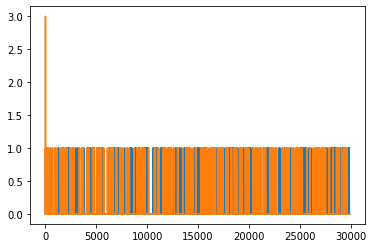

In [10]:
plt.plot(ystate_list[0])
plt.plot(zstate_list[0])

Calculate information

In [11]:
window = [-1,1] # second
Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, Information_list[i] = PIfunc(xstate_list[i], ystate_list[i], zstate_list[i], dt, window)
    timeshift = np.flip(timeshift)

## Plot

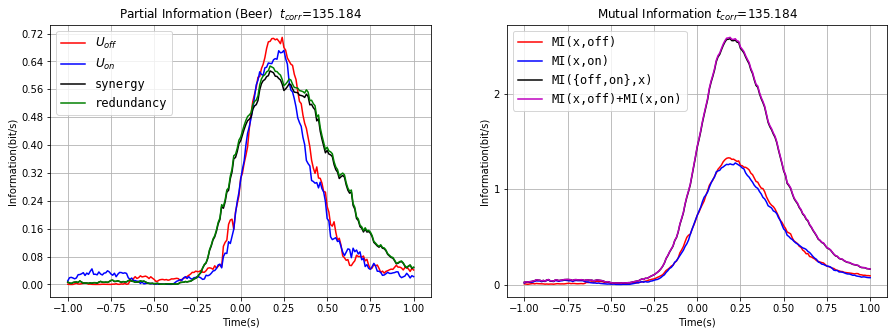

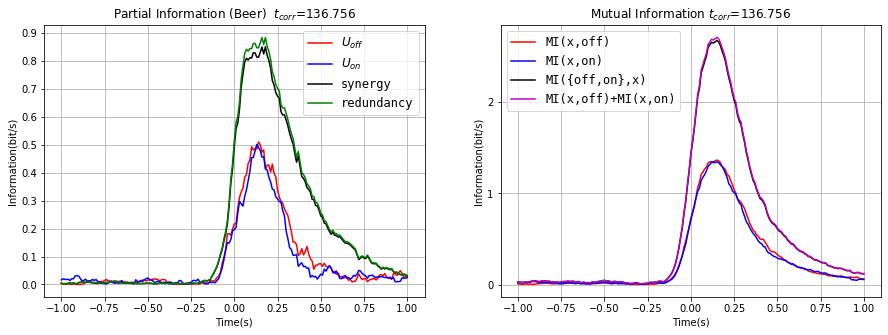

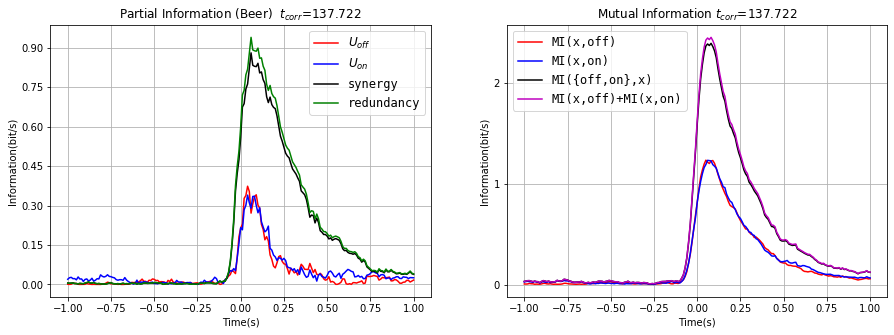

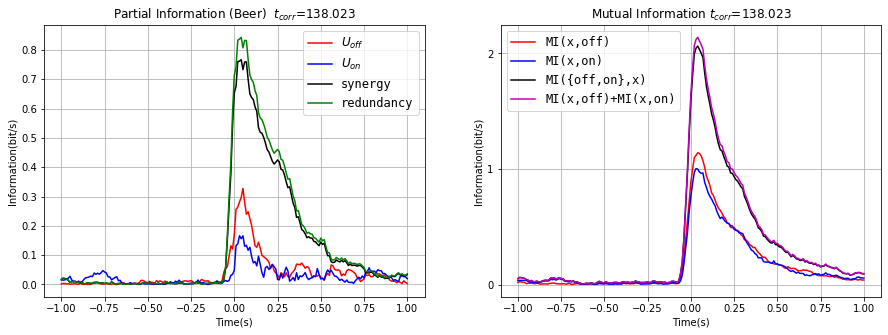

In [12]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_{off}$', r'$U_{on}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,off)', 'MI(x,on)', 'MI({off,on},x)', 'MI(x,off)+MI(x,on)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

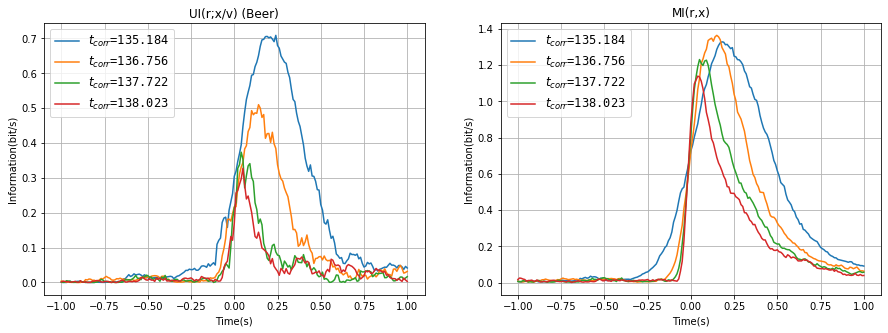

In [13]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

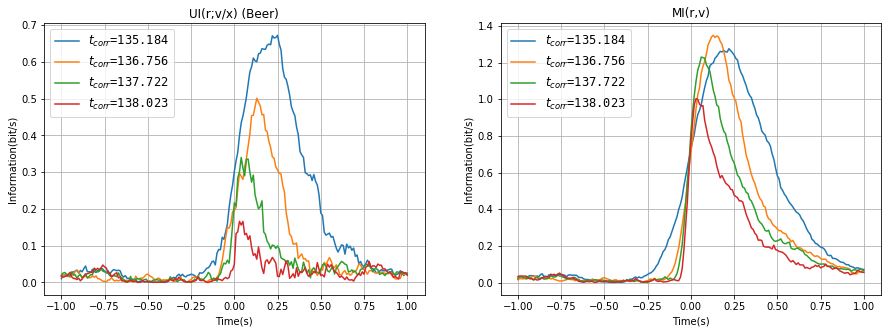

In [14]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

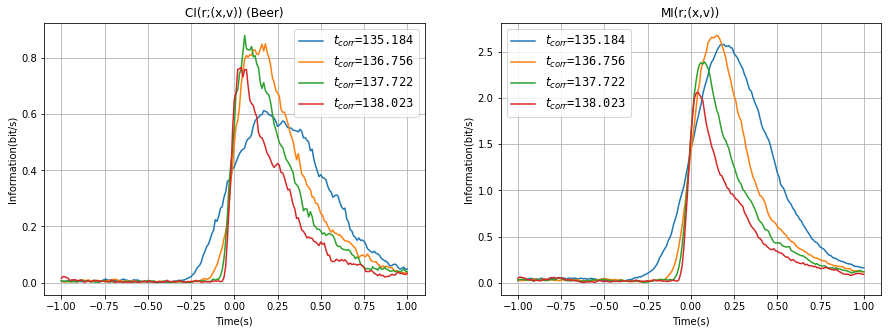

In [15]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)